# Exploring Inference Hooks in LLM Interface

In [17]:
#Here is an example snippet illustrating what an activation hooking API could look like in Glassbox. It is designed to be user-friendly for attaching hooks to transformer models (like Hugging Face transformers) to capture attention weights, residual streams, or neuron activations during a forward pass:

import torch
from transformers import GPT2Model, GPT2Tokenizer

class GlassboxModelWrapper:
    def __init__(self, model):
        self.model = model
        self.hooks = []
        self.captured_activations = {}

    def attach_hook(self, layer_name, hook_fn):
        """
        Attach a forward hook to capture activations from a specified layer.
        - layer_name: string identifying the module/layer in the model
        - hook_fn: a function with signature hook(module, input, output)
        """
        layer = dict(self.model.named_modules())[layer_name]
        handle = layer.register_forward_hook(hook_fn)
        self.hooks.append(handle)

    def remove_hooks(self):
        for handle in self.hooks:
            handle.remove()
        self.hooks = []

    def capture_attention_hook(self, module, input, output):
        # Example: store attention weights (assuming output is attn weights)
        if isinstance(output, tuple) and len(output) > 1:
            attn = output[1]
        else:
            attn = None

        self.captured_activations["attention"] = (
            attn.detach().cpu() if attn is not None else None
        )
    def capture_residual_hook(self, module, input, output):
        # Example: store residual stream activation
        try:
            self.captured_activations["residual"] = output.detach().cpu()
        except AttributeError:
            self.captured_activations["residual"] = None


    def run_with_hooks(self, input_ids):
        # Clear previous activations
        self.captured_activations.clear()

        # Attach hooks
        self.attach_hook("h.0.attn", self.capture_attention_hook)
        self.attach_hook("h.0.mlp", self.capture_residual_hook)

        # Run forward pass
        with torch.no_grad():
            outputs = self.model(input_ids)

        # Remove hooks after forward pass
        self.remove_hooks()

        # Return model outputs and captured activations
        return outputs, self.captured_activations


# Usage Example:
import torch
from transformers import GPT2Model, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# Must set attn_implementation to "eager" to enable hook capturing, otherwise SDPA is used which does not support hooks
model = GPT2Model.from_pretrained("gpt2", attn_implementation="eager", output_attentions=True)
glassbox_model = GlassboxModelWrapper(model)

input_text = "The quick brown fox"
input_ids = tokenizer(input_text, return_tensors="pt")["input_ids"]

for name, module in model.named_modules():
    print(name)

outputs, activations = glassbox_model.run_with_hooks(input_ids)
print("Captured Attention Shape:", activations['attention'].shape)
print("Captured Residual Shape:", activations['residual'].shape)

#Explanation:
'''This example wraps a Hugging Face GPT-2 model.

The attach_hook method registers PyTorch forward hooks on specific submodules (based on layer/module names).

The hooks save intermediate activations (like attention weights, residual stream outputs) during the forward pass into a dictionary.

Hooks are removed immediately after to avoid side-effects.

Users get back both the model output and fine-grained internal activations for inspection or further analysis.

Such an intuitive API would allow Glassbox users to easily attach or swap hooks on different layers or components, retrieve relevant internal states at runtime, and build interpretability tools on top of these activations.

This pattern is widely used in existing libraries such as TransformerLens but can be simplified and generalized in Glassbox to support multiple modern architectures and custom interpretability workflows.
'''

'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /gpt2/resolve/main/tokenizer_config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002097F9C5010>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 10d32d03-814b-4c65-9682-1481824bd468)')' thrown while requesting HEAD https://huggingface.co/gpt2/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /gpt2/resolve/main/tokenizer_config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020901258D10>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 2c9cd72e-ae40-4f8f-8f52-6a5b7d400982)')' thrown while requesting HEAD https://huggingface.co/gpt2/resolve/main/tokenizer_config.json
Retrying in 2s [Retry 2/5].
'(MaxR

KeyboardInterrupt: 

### Observation Hooks
#### attach_hooks(self, layer_name, hook_fn)
Attach hooks to models
#### remove_hooks(self)
Remove hooks from models, because if we don't each time we run the model, the hooks will accumulate
#### pre_forward_hook(self, module, input)
What it does: Intercepts and captures the input to a layer before it processes anything.
Use case: See what data is entering a layer, useful for debugging or understanding data flow.
#### forward_hook(self, module, input, output)
What it does: Intercepts and captures the output of a layer after it processes data during the forward pass.
Use case: See what activations a layer produces for given input.
#### tensor_observer_hook(module, input, output)
**Note: need to make this read-only so that we can't modify the tensors.
What it does: Attaches directly to specific tensors (not whole layers) to observe their values during computation.
Use case: Track specific embeddings, hidden states, or intermediate computations.

### Analysis Methods
#### compute_activation_stats(self)
What it does: Computes mathematical statistics (mean, std, min, max, sparsity) on captured activations.
Use case: Understand the distribution and behavior of activations across layers.
#### get_dead_neurons(self, threshold=0.01)
#### get_neuron_importance(self, layer_name, method='variance')
What it does: Identifies "dead neurons" (rarely activate) and ranks neuron importance.
Use case: Find which neurons are contributing vs. doing nothing; optimize or prune models.
#### extract_attention_patterns(self, layer_name)
What it does: Extracts and analyzes attention weights to see what the model is "looking at."
Use case: Understand which tokens the model focuses on; interpret model decisions.
#### extract_features(self, input_ids, layers_to_extract)
What it does: Captures activations from multiple layers simultaneously in one forward pass.
Use case: Build feature representations from different depths; compare early vs. late layers.
#### get_layer_info(self)
#### memory_footprint(self)
What it does: Provides metadata about the model structure, parameters, and memory usage.
Use case: Understand model architecture; debug memory issues; profile performance.
#### compare_activations(self, input_ids_1, input_ids_2, layers_to_compare)
What it does: Compares activations between two different inputs to see how the model responds differently.
Use case: Understand what makes the model produce different outputs; analyze decision boundaries.

### Export and Format Activations
What it does: Saves captured activations to disk or converts them to different formats.
Use case: Save results for later analysis; export to visualization tools; share with team.
#### export_activations(self, filepath, format='torch')
#### load_activations(self, filepath)
#### to_numpy(self)
#### to_dict(self)

### Inference Modifications - Abstract Class
#### ablate(self, *args, **kwargs)
#### test_importance(self, *args, **kwargs)

### Inference Modifications on a Neuron Level
What it does: Zeros out specific neurons during inference to test their importance.
Use case: Identify which neurons are critical for certain predictions; understand redundancy.
#### ablate(self, layer_name, neuron_indices)
#### test_importance(self, input_ids, layer_name, neuron_idx)

### Inference Modifications on a Layer Level
What it does: Completely skips a layer by passing input directly through (identity function).
Use case: Test if certain layers are necessary; understand layer contributions.
#### ablate(self, layer_name)
#### test_importance(self, input_ids, layers_to_test)

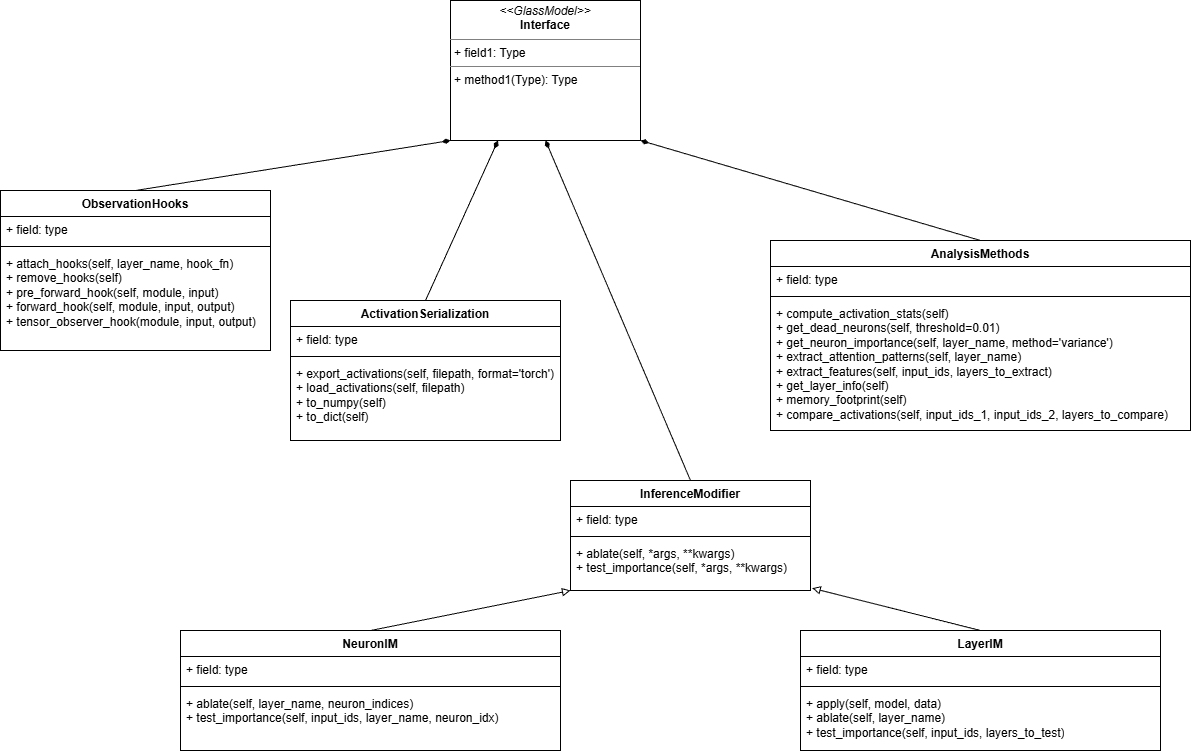